# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Сначала загрузим необходимые библиотеки и данные

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q scikit-learn
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats
import optuna
import phik
import shap


#Графики
import seaborn as sns
import matplotlib.pyplot as plt
from re import template
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from phik.report import plot_correlation_matrix




# Модели МО
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Разбивка данных + обработка признаков 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Метрики для Линейной Регрессии
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Метрики для Логистической Регрессии
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score,make_scorer

# Для подбора гиперпараметров 
from optuna import distributions
from optuna.integration import OptunaSearchCV

# Интерпритация модели
from sklearn.inspection import permutation_importance



# Для создания пайплайна 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>
<h3> Широкоформатный Jupyter <a class="tocSkip"> </h3>
    
Расширяем границы, или как сделать работу более комфортной (не всем нравится 😄)

    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))


In [3]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')


In [4]:
# У меня была классная функция для знакомства с данными: 
def quick_eda_report(df):
    
        print(f'\n{"="*50}\n📊 Анализ датасета: \n{"="*50}')
        
        print('\n🔹 Размерность:', df.shape)
        
        print('\n🔹 Типы данных и информация:')
        display(df.info(verbose=False, memory_usage='deep'))
        
        print('\n🔹 Первые 5 строк:')
        display(df.head())

        print('\n🔹 Случайные 5 строк:')
        display(df.sample(5, random_state=42))

        print('\n🔹 Кол-во дубликатов:', df.duplicated().sum())
        
        print('\n🔹 Пропуски по столбцам:')
        nulls = df.isnull().sum()
        display(nulls[nulls > 0].sort_values(ascending=False))

        print('\n' + '-'*50)

In [5]:
quick_eda_report(df0)


📊 Анализ датасета: 

🔹 Размерность: (100000, 5)

🔹 Типы данных и информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5 entries, id to product
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None


🔹 Первые 5 строк:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



🔹 Случайные 5 строк:


,id,f0,f1,f2,product
75721,7C6bA,0.599283,-0.557623,2.121187,122.073350
80184,dVxsn,0.739017,-0.463156,-1.347584,48.738540
19864,1Gm3l,1.422743,-0.534917,3.718798,131.338088
76699,Nzg1t,1.580244,-0.238458,2.805149,88.327757
92991,Z7b4F,0.918974,0.023961,2.598575,36.959266



🔹 Кол-во дубликатов: 0

🔹 Пропуски по столбцам:


Series([], dtype: int64)


--------------------------------------------------


In [6]:
quick_eda_report(df1)


📊 Анализ датасета: 

🔹 Размерность: (100000, 5)

🔹 Типы данных и информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5 entries, id to product
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None


🔹 Первые 5 строк:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



🔹 Случайные 5 строк:


,id,f0,f1,f2,product
75721,fYVDK,6.078076,0.084568,0.002957,0.000000
80184,3SQcq,16.462386,2.712946,1.993030,53.906522
19864,hQ1gJ,7.051898,0.766983,4.990194,134.766305
76699,Y4vux,-0.240045,-0.380804,3.999693,107.813044
92991,H1NUw,13.350111,-8.558281,0.002010,0.000000



🔹 Кол-во дубликатов: 0

🔹 Пропуски по столбцам:


Series([], dtype: int64)


--------------------------------------------------


In [7]:
quick_eda_report(df2)


📊 Анализ датасета: 

🔹 Размерность: (100000, 5)

🔹 Типы данных и информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5 entries, id to product
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None


🔹 Первые 5 строк:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



🔹 Случайные 5 строк:


,id,f0,f1,f2,product
75721,sPjbT,2.111118,-1.679773,3.112240,117.441301
80184,1u4uo,0.734759,0.747788,3.670879,47.841249
19864,kZ6HO,-2.513109,0.844631,-4.922889,45.883483
76699,gCZGK,-2.035301,-1.522988,5.072839,139.014608
92991,rqJHx,2.744145,1.429952,-1.372661,84.004276



🔹 Кол-во дубликатов: 0

🔹 Пропуски по столбцам:


Series([], dtype: int64)


--------------------------------------------------


In [8]:
# функция из предидущих работ для анализа количественных данных
def analyze_numerical_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика для признака: {feature}")
        display(df[feature].describe())
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Гистограмма
        axes[0].set_title(f'Распределение {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')

        if target:
            sns.histplot(data=df, x=feature, hue=target, kde=True, bins=20, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, bins=20, ax=axes[0])
        
        # Boxplot
        axes[1].set_title(f'Boxplot для {feature}', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, x=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)

In [9]:
quant_features = [
    'f0', 'f1', 'f2','product'
]

📊 Статистика для признака: f0


count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

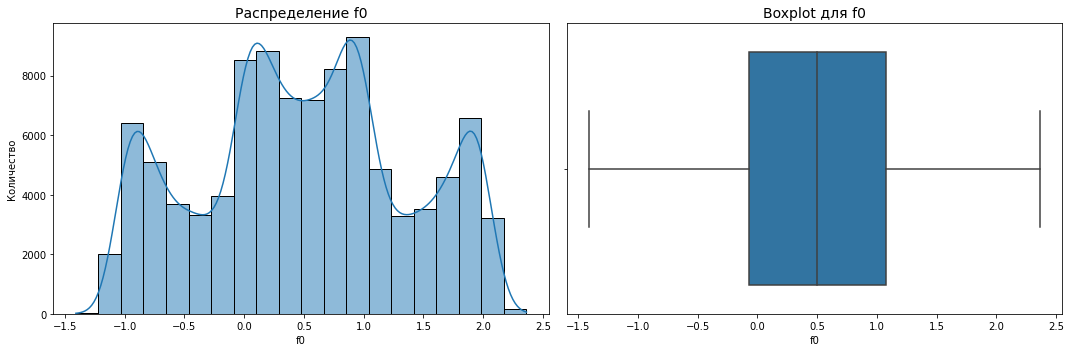

------------------------------------------------------------
📊 Статистика для признака: f1


count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

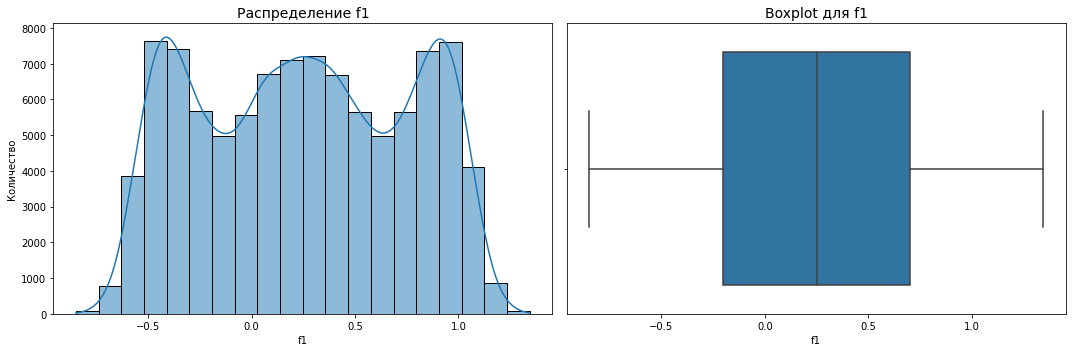

------------------------------------------------------------
📊 Статистика для признака: f2


count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

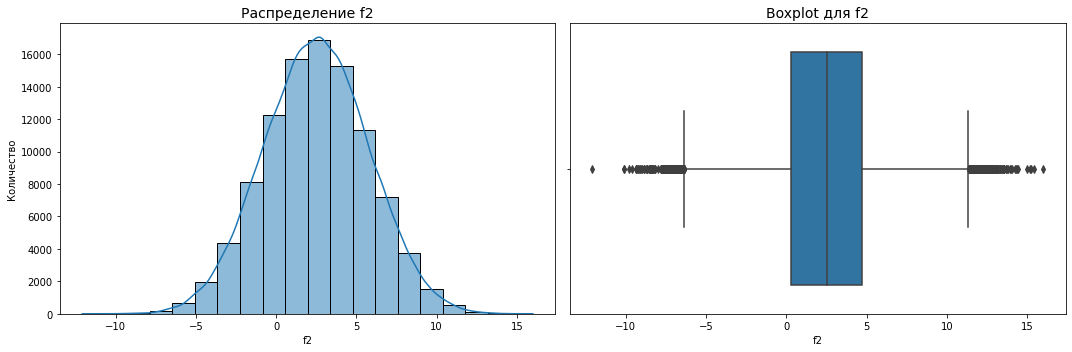

------------------------------------------------------------
📊 Статистика для признака: product


count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

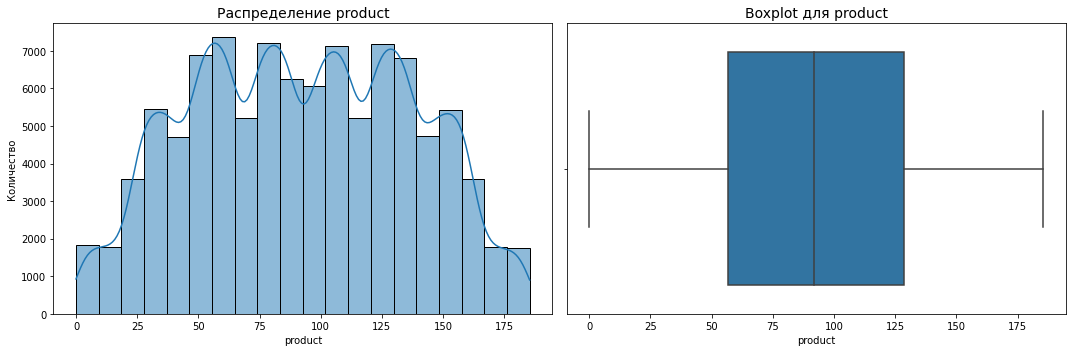

------------------------------------------------------------


In [10]:
analyze_numerical_features(df0,quant_features)

📊 Статистика для признака: f0


count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

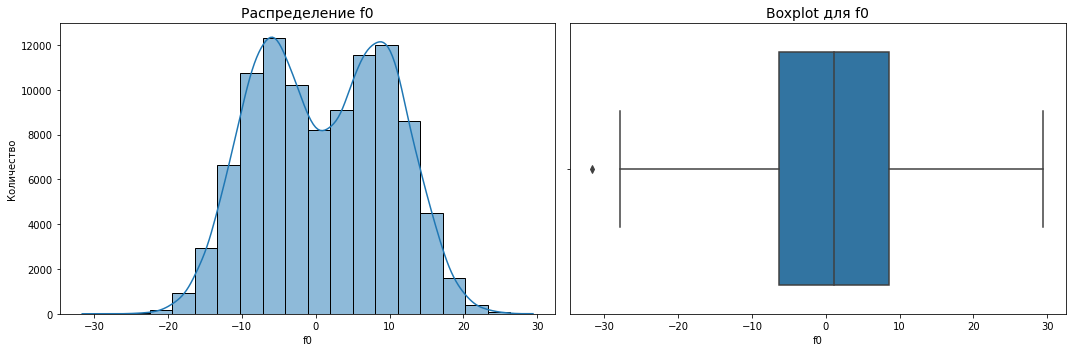

------------------------------------------------------------
📊 Статистика для признака: f1


count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64

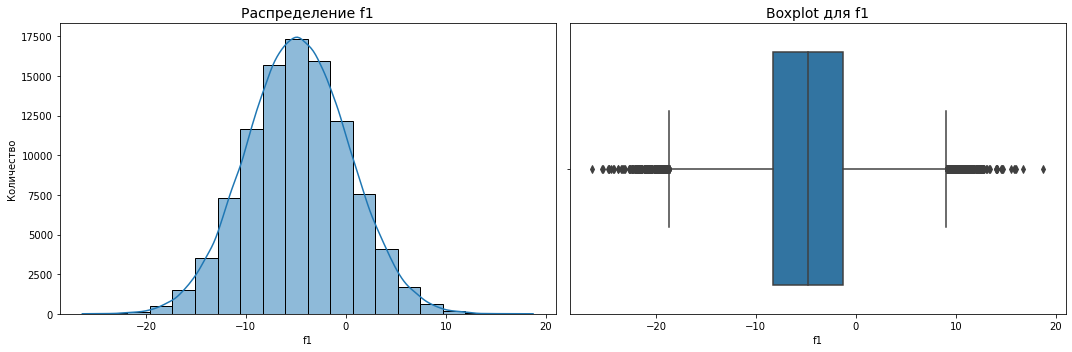

------------------------------------------------------------
📊 Статистика для признака: f2


count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

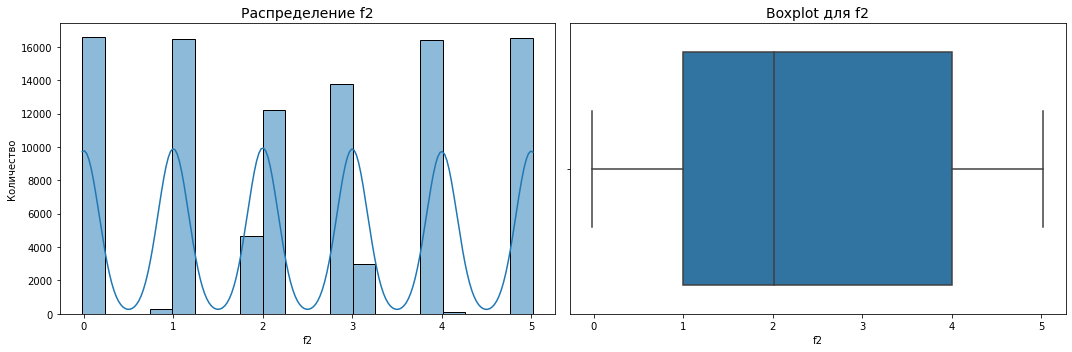

------------------------------------------------------------
📊 Статистика для признака: product


count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

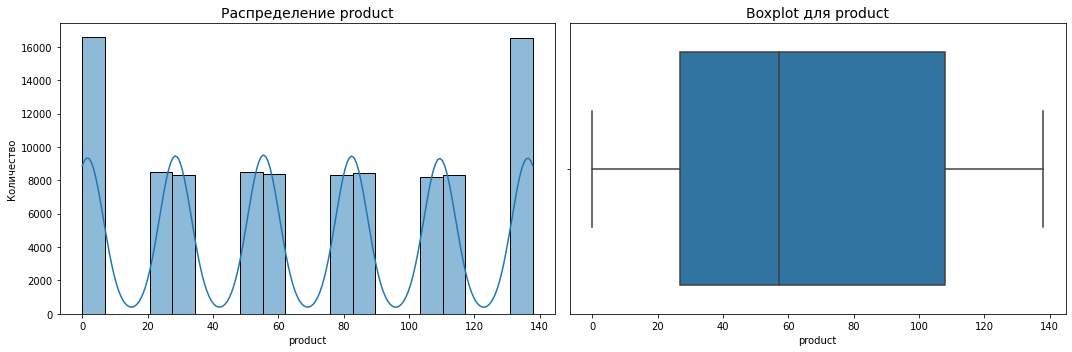

------------------------------------------------------------


In [11]:
analyze_numerical_features(df1,quant_features)

📊 Статистика для признака: f0


count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

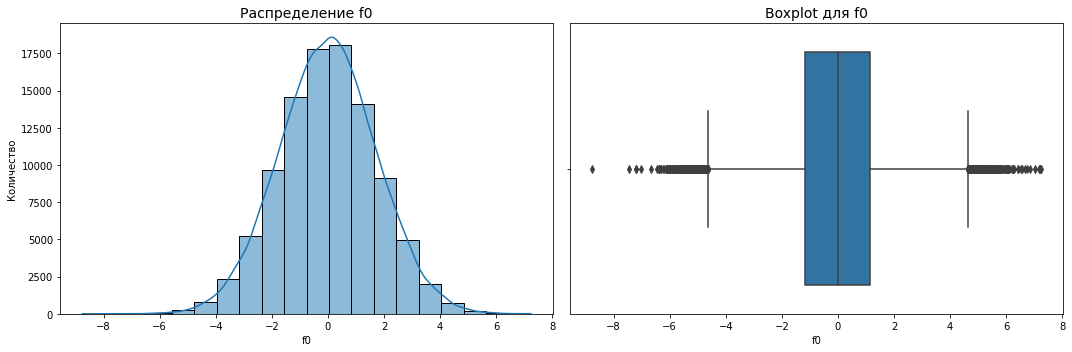

------------------------------------------------------------
📊 Статистика для признака: f1


count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

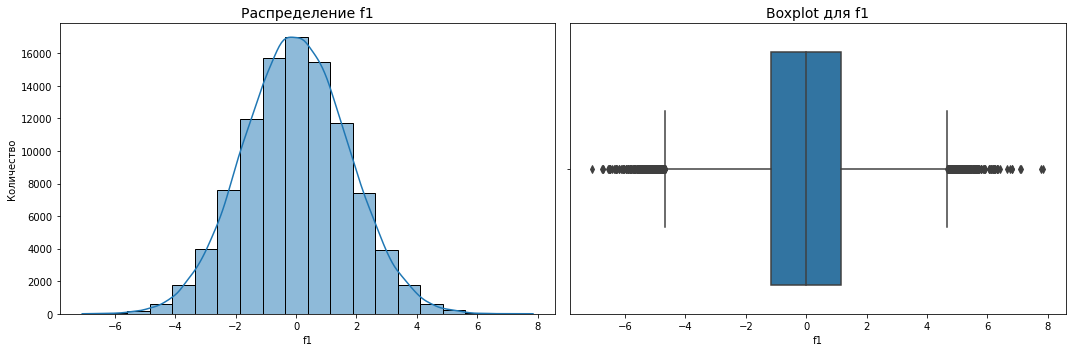

------------------------------------------------------------
📊 Статистика для признака: f2


count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

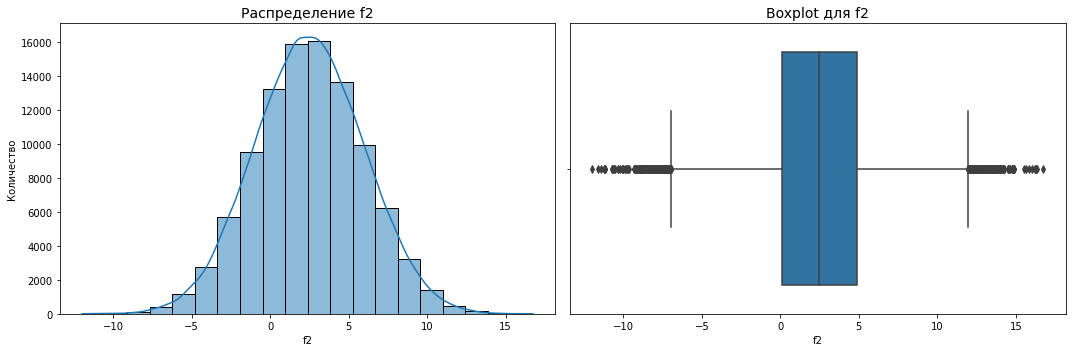

------------------------------------------------------------
📊 Статистика для признака: product


count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

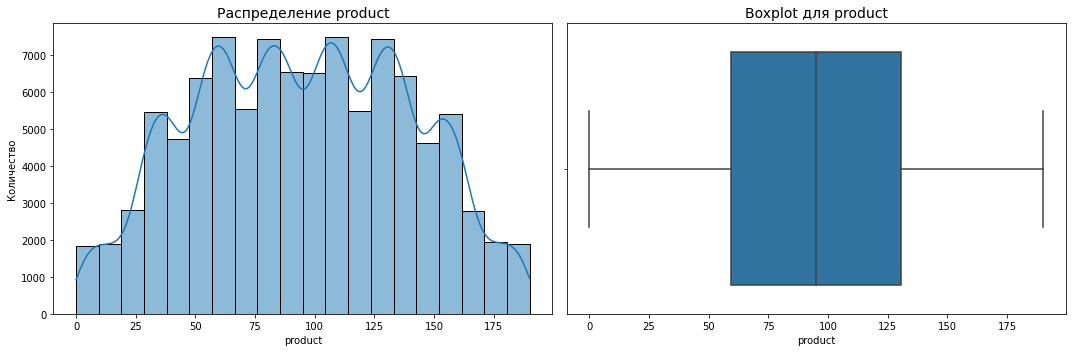

------------------------------------------------------------


In [12]:
analyze_numerical_features(df2,quant_features)

### Вывод:
- Пропусков нет
- Дубликатов нет 
- Данные визуально примерно одинаковые.


## Обучение и проверка модели

In [13]:
# Выделим целевой признак и разобьем на тестовую и тренировочные выборки.
# Так как операцию повторять будем 3 раза(по количеству датасетов), используем функцию:
# Функция подготовки данных перед подбором моделей и их параметров
def data_preprocessing(geo_data):
    
    # Разделение датафреймов на целевую и нецелевую выборку
    features = geo_data.drop(['id', 'product'], axis=1)
    target = geo_data['product']

    # Значение "random_state"
    state = 42

    # Разделение целевой и нецелевой выборки 
    # на обучающие и тестовые выборки
    features_train,  features_test, target_train, target_test = train_test_split(
        features, 
        target, 
        test_size=.25, 
        random_state=state
    )
    
    return features_train,  features_test, target_train, target_test

In [14]:
# Функция создания структуры пайплайна
def params_and_model_selection(features_train, features_test, target_train, target_test):
    # Явная стандартизация признаков
    scaler = StandardScaler()
    
    # Обучаем scaler на тренировочных данных и преобразуем train/test выборки
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)

    # Объявляем модель
    model = LinearRegression()

    # Обучаем модель на масштабированных данных
    model.fit(features_train_scaled, target_train)

    # Предсказания
    predictions = model.predict(features_test_scaled)

    # Метрики
    actual_mean = target_test.mean()
    predicted_mean = predictions.mean()
    rmse = np.sqrt(mean_squared_error(target_test, predictions))

    # Вывод результатов
    print(f'Средняя фактическая выработка: {actual_mean:.2f}')
    print(f'Средняя предсказанная выработка: {predicted_mean:.2f}')
    print(f'RMSE: {rmse:.2f}')

    return predictions, target_test, model    
   


In [15]:
# первый датасет - для первого региона
features_0_train,  features_0_test, target_0_train, target_0_test = data_preprocessing(df0)


In [16]:
predictions0, target_test0, pipe0 = params_and_model_selection(features_0_train,  features_0_test, target_0_train, target_0_test)


Средняя фактическая выработка: 92.33
Средняя предсказанная выработка: 92.40
RMSE: 37.76


In [17]:
# второй датасет - для второго региона

features_1_train,  features_1_test, target_1_train, target_1_test = data_preprocessing(df1)


In [18]:
# предсказания для второго
predictions1, target_test1, pipe1 = params_and_model_selection(features_1_train,  features_1_test, target_1_train, target_1_test)

Средняя фактическая выработка: 68.73
Средняя предсказанная выработка: 68.71
RMSE: 0.89


In [19]:
# третий датасет - для третьего региона
features_2_train,  features_2_test, target_2_train, target_2_test = data_preprocessing(df2)


In [20]:
# предсказания для третьего
predictions2, target_test2, pipe2 = params_and_model_selection(features_2_train,  features_2_test, target_2_train, target_2_test)

Средняя фактическая выработка: 95.15
Средняя предсказанная выработка: 94.77
RMSE: 40.15


### Вывод: 
- Самая точная модель по метрике RMSE(квадратный корень из суммы квадратов ошибок, деленный на количество объектов). Эту модель и будем использовать.

## Подготовка к расчёту прибыли

### Ключевые значения - в переменные:



In [21]:
# 10 млрд - наш бюджет
BUDGET = 10000000000  
# доход с 1 тыс. баррелей
REVENUE_PER_UNIT = 450000  
# количество точек
TOTAL_WELLS = 500 
# используемые
SELECTED_WELLS = 200
# Количество выборок Bootstrap  
BOOTSTRAP_SAMPLES = 1000
# Довертельный интервал в 95%
INTERVAL = .95


### Расчеты

#### Логика расчетов:
- Нам нужно посчтиать минимальный объем на скважину
- Бюджет необходимо поделить на произведение дохода с 1 тыс. барралей с количеством скважин. 

In [22]:
min_volume = BUDGET / (REVENUE_PER_UNIT * SELECTED_WELLS)
print(f"Минимальный объём сырья для безубыточности: {min_volume:.2f} тыс. баррелей")

Минимальный объём сырья для безубыточности: 111.11 тыс. баррелей


In [26]:
#### У меня есть данные по целевому признаку по каждому региону. Можно взять среднее:
target_0_full = pd.concat([target_0_train, target_0_test])
target_1_full = pd.concat([target_1_train, target_1_test])
target_2_full = pd.concat([target_2_train, target_2_test])


In [27]:
mean_0 = target_0_full.mean()
mean_1 = target_1_full.mean()
mean_2 = target_2_full.mean()
print(f"Средний запас в регионе 0: {mean_0:.2f} тыс. баррелей")
print(f"Средний запас в регионе 1: {mean_1:.2f} тыс. баррелей")
print(f"Средний запас в регионе 2: {mean_2:.2f} тыс. баррелей")


Средний запас в регионе 0: 92.50 тыс. баррелей
Средний запас в регионе 1: 68.82 тыс. баррелей
Средний запас в регионе 2: 95.00 тыс. баррелей


### Вывод по разделу: 
- Если брать скважины наугад, то ни один регион не окупится. 
- Нам необходимо отобрать 200 лучших скважин, для максимальной прибыли. 


## Расчёт прибыли и рисков 

### Далее мы возьмем скважины с максимальными значениями предсказаний. 

In [28]:
# напишем функцию для 200 лучших значений
def calculate_profit(predictions, target, count=SELECTED_WELLS, profit_per_unit=REVENUE_PER_UNIT):
    # Получаем индексы 200 лучших предсказаний
    selected_indices = predictions.sort_values(ascending=False).index[:count]
    
    # Извлекаем реальные значения для этих индексов
    selected_targets = target[selected_indices]
    
    # Считаем прибыль
    total_profit = selected_targets.sum() * profit_per_unit
    return total_profit

In [34]:
# Переведем массив в датафрейм с сохранением индексов:
predictions0 = pd.Series(predictions0, index=target_0_test.index)
predictions1 = pd.Series(predictions1, index=target_1_test.index)
predictions2 = pd.Series(predictions2, index=target_2_test.index)

In [33]:
profit_0 = calculate_profit(predictions0, target_0_test)
print(f"Прибыль в регионе 1: {profit_0:,.0f} руб.")

Прибыль в регионе 1: 13,359,141,114 руб.


In [35]:
profit_1 = calculate_profit(predictions1, target_1_test)
print(f"Прибыль в регионе 2: {profit_1:,.0f} руб.")

Прибыль в регионе 2: 12,415,086,697 руб.


In [36]:
profit_2 = calculate_profit(predictions2, target_2_test)
print(f"Прибыль в регионе 1: {profit_2:,.0f} руб.")

Прибыль в регионе 1: 12,598,571,759 руб.


### Вывод:
- При полученном объеме сырья,если выбрать 200 лучших скважин, то самая большая прибыль в первом регионе. 

# Расчеты с Bootstrap

In [56]:
#  Напишем функцию
def bootstrap_profit(predictions, # предсказанные значения
                     target, # реальные значения
                     n_iterations=BOOTSTRAP_SAMPLES, # сколько раз повторяем Bootstrap
                     sample_size=TOTAL_WELLS, # сколько скважин выбираем
                     top_count=SELECTED_WELLS, # сколько из них лучших отбирается
                     profit_per_unit=REVENUE_PER_UNIT, # доход с 1000 бараллей
                     total_cost=BUDGET, # фикса расходов на разработку региона
                     RANDOM_STATE=12345 #
                    ):
    state = np.random.RandomState(RANDOM_STATE)
    profits = []
    
    for i in range(n_iterations):
        # Шаг 1: Bootstrap — выбор 500 скважин
        sample_indices = state.choice(predictions.index, size=sample_size, replace=True)
        
        # Шаг 2: Из них выбираем 200 лучших по предсказаниям
        top_indices = predictions.loc[sample_indices].sort_values(ascending=False).index[:top_count]
        
        # Шаг 3: Прибыль по фактическим значениям
        revenue = target.loc[top_indices].sum() * profit_per_unit
        profit = revenue - total_cost
        
        profits.append(profit)
        
    return pd.Series(profits)


In [54]:
profits_0 = bootstrap_profit(predictions0, target_0_test)
profits_1 = bootstrap_profit(predictions1, target_1_test)
profits_2 = bootstrap_profit(predictions2, target_2_test)

In [43]:
# Сделаем функцию для анализа резултатоов:
def show_profit_stats(profits, region_name):
    print(f"\nРегион {region_name}")
    print(f"Средняя прибыль: {profits.mean():,.0f} руб.")
    print(f"95% интервал: [{profits.quantile(0.025):,.0f}, {profits.quantile(0.975):,.0f}] руб.")
    print(f"Риск убытков: {(profits < 0).mean() * 100:.2f}%")

In [55]:
show_profit_stats(profits_0, '1')
show_profit_stats(profits_1, '2')
show_profit_stats(profits_2, '3')


Регион 1
Средняя прибыль: 406,278,783 руб.
95% интервал: [-117,742,136, 911,737,051] руб.
Риск убытков: 6.70%

Регион 2
Средняя прибыль: 432,624,132 руб.
95% интервал: [16,846,175, 815,972,526] руб.
Риск убытков: 1.90%

Регион 3
Средняя прибыль: 377,362,192 руб.
95% интервал: [-170,780,418, 901,772,131] руб.
Риск убытков: 7.40%


## Вывод / Рекомендация бизнесу:
- Для разработки рекомендован регион №2:
- Данный регион подходит по условию задания 1,9% риск убытков (Должно быть меньше 2,5%, что является 0.025 квантилью от от общего профита)
- Как следствие, отсутствие убытков и самая большая возможная средняя прибыль. 
- Регион сочетаем в себе высокий потенциал дохода и минимальные риски. 


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован